In [1]:
import json
import string
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
from typing import List

from ml4wifi import plots

APS_NAMES = string.ascii_uppercase
RESULTS_FILE = "/Users/wciezobka/ncn/mapc-mab/all_results.json"
AP_GROUPS_SORTED = ['A', 'B', 'D', 'C', 'AC', 'BD', 'CD', 'BC', 'AD', 'AB', 'ACD', 'BCD', 'ABC', 'ABD', 'ABCD']

with open(RESULTS_FILE, 'r') as file:
        results = json.load(file)

In [2]:
args_scenario = "scenario_10m"
args_agent = "UCB"
txops_slots_range = range(0, 1)
run = 0

scenario = next(filter(lambda x: x['scenario']['name'] == args_scenario, results)) if args_scenario else results[0]
agent = next(filter(lambda x: x['agent']['name'] == args_agent, scenario['agents'])) if args_agent else scenario['agents'][0]
n_runs = 1 #len(agent['runs'])
txops_slots = len(txops_slots_range)

### Stations groupping

### APs' groups groupping

In [3]:
def plot_histogram_ap(actions: List, txops_slots: int, save_name: str) -> None:
    _, ax = plt.subplots(figsize=(8, 4))
    ax.bar([x[0] for x in actions], [x[1] for x in actions])
    ax.set_xlabel("APs' groups")
    ax.set_ylabel("Transmission opportunities")
    ax.set_title(
        "Histogram of simultaneously transmitting APs' groups" +
        f"\nTotal slots: {txops_slots}"
    )
    plt.xticks(rotation=90)
    plt.tight_layout()
     # plt.savefig(save_name, bbox_inches='tight')
    # plt.clf()
    plt.show()

In [4]:
def ap_grouping(txops_slots_range: range, run: int, plot: bool = True):
    # Define frequency dict of actions
    actions_dict = defaultdict(lambda: 0)

    # Count actions
    for r in agent["actions"][run:run+1]:
        for action in r[txops_slots_range.start:txops_slots_range.stop]:
            # Cast action to immutable type
            action = tuple([tuple(tx) for tx in action])
            actions_dict[action] += 1

    # Sort actions by frequency
    actions = sorted(actions_dict.items(), key=lambda x: x[1], reverse=True)

    # Scale actions by number of runs
    actions = [(action, freq / n_runs) for action, freq in actions]

    # Convert actions to APs' names
    action_to_names = lambda tx: "".join([APS_NAMES[i] for i, tx in enumerate(tx) if tx])
    actions_aps = [(action_to_names(tx), freq) for tx, freq in actions]

    # Aggregate actions by tx APs
    actions_aps_aggregated = defaultdict(lambda: 0)
    actions_aps_aggregated = {k: 0 for k in AP_GROUPS_SORTED}
    for action, freq in actions_aps:
        actions_aps_aggregated[action] += freq

    # Re-run sorting
    # actions_aps_aggregated = sorted(actions_aps_aggregated.items(), key=lambda x: x[1], reverse=True)
    actions_aps_aggregated = list(actions_aps_aggregated.items())

    # Plot histogram of actions_aps_aggregated
    save_name = f"aggregating-by-APs-{scenario['scenario']['name']}-{agent['agent']['name']}.pdf"

    if plot:
        plot_histogram_ap(actions_aps_aggregated, txops_slots, save_name)

    return actions_aps_aggregated

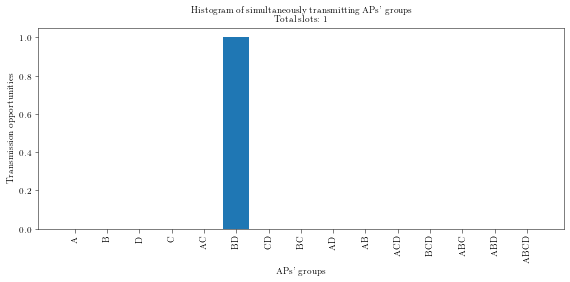

In [5]:
slot = 106
ap_grouping(txops_slots_range=range(slot, slot+1), run=6);

In [6]:
# Select run to visualize
run = 0

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for slot in range(scenario['scenario']['n_steps']):
    actions = ap_grouping(txops_slots_range=range(slot, slot+1), run=1, plot=False)
    fig.add_trace(go.Bar(
        visible=False,
        x=[x[0] for x in actions],
        y=[x[1] for x in actions]
    ))
fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    slot = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},],  # layout attribute
        label = f"{i + 1}"
    )
    slot["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(slot)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "TXOP slot: "},
    pad={"t": 15},
    steps=steps
)]

fig.update_layout(sliders=sliders)
fig.show()